<sup> Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved. SPDX-License-Identifier: MIT-0</sup>

# Techniques for Automatic Summarization of Documents Using Language Models

In this notebook, we are exploring various types of summarization and different approaches in their application. We will be heavily using large language models and langchain.

**Types of Summarization:**
 * Extractive Summarization
 * Abstractive Summarization
 * Multi-Level Summarization:
     * Extractive-Abstractive Summarization
     * Abstractive-Abstractive Summarization

**Recommended SageMaker notebook environment configuration:**
 * Kernel: Python 3 (Data Science 3.0)
 * Instance Type: ml.c5.4xlarge
 * Disclaimer: This code has been tested and confirmed to work with the current version of Langchain 0.0.335. Please ensure that your Langchain package, along with any other dependencies listed below, are up to date to guarantee compatibility and optimal performance. Version discrepancies may lead to unexpected behavior or errors.

### Install Dependencies

In [2]:
!pip3 install langchain openai tiktoken pypdf bert-extractive-summarizer faiss-cpu cohere -U sentence-transformers --quiet


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


### Input API Keys
Here are links to the instructions on how to obtain API keys from [OpenAI](https://platform.openai.com/docs/quickstart/step-2-setup-your-api-key) and [Cohere](https://docs.aicontentlabs.com/setting-up-api-keys/cohere-api-key/)

In [3]:
import os

In [4]:
os.environ['OPENAI_API_KEY'] = <YOUR_OPEN_AI_API_KEY>
os.environ['COHERE_API_KEY'] = <YOUR_COHERE_API_KEY>

## Data

We are using the AWS well architected framework documentation as the input data available in this [link](https://docs.aws.amazon.com/pdfs/wellarchitected/latest/framework/wellarchitected-framework.pdf). To start we are using a small snippet of the data to introduce abstractive and extractive summary.

In [5]:
text_snippet = """
The AWS Well-Architected Framework helps you understand the pros and cons of decisions you make
while building systems on AWS. Using the Framework helps you learn architectural best practices for
designing and operating secure, reliable, efficient, cost-effective, and sustainable workloads in the AWS
Cloud. It provides a way for you to consistently measure your architectures against best practices and
identify areas for improvement. The process for reviewing an architecture is a constructive conversation
about architectural decisions, and is not an audit mechanism. We believe that having well-architected
systems greatly increases the likelihood of business success.
AWS Solutions Architects have years of experience architecting solutions across a wide variety
of business verticals and use cases. We have helped design and review thousands of customers’
architectures on AWS. From this experience, we have identified best practices and core strategies for
architecting systems in the cloud.
The AWS Well-Architected Framework documents a set of foundational questions that help you to
understand if a specific architecture aligns well with cloud best practices. The framework provides a
consistent approach to evaluating systems against the qualities you expect from modern cloud-based
systems, and the remediation that would be required to achieve those qualities. As AWS continues to
evolve, and we continue to learn more from working with our customers, we will continue to refine the
definition of well-architected.
This framework is intended for those in technology roles, such as chief technology officers (CTOs),
architects, developers, and operations team members. It describes AWS best practices and strategies
to use when designing and operating a cloud workload, and provides links to further implementation
details and architectural patterns. For more information, see the AWS Well-Architected homepage.
AWS also provides a service for reviewing your workloads at no charge. The AWS Well-Architected
Tool (AWS WA Tool) is a service in the cloud that provides a consistent process for you to review and
measure your architecture using the AWS Well-Architected Framework. The AWS WA Tool provides
recommendations for making your workloads more reliable, secure, efficient, and cost-effective.
To help you apply best practices, we have created AWS Well-Architected Labs, which provides you with
a repository of code and documentation to give you hands-on experience implementing best practices.
We also have teamed up with select AWS Partner Network (APN) Partners, who are members of the AWS
Well-Architected Partner program. These AWS Partners have deep AWS knowledge, and can help you
review and improve your workloads.
"""

## Extractive Summarization

This techniques "extracts" important text from the passage to create a summary. It does not perform any paraphrasing which makes its output less cohesive. Due to its simplicity, the model can be ran without any special hardware and produces output quickly. For this example we are using the [bert extractive summarizer](https://pypi.org/project/bert-extractive-summarizer/).

### Load Model

In [6]:
from summarizer import Summarizer
model = Summarizer()

### Kick-off summarization

In [7]:
bert_summary = model(text_snippet, num_sentences=10)

In [8]:
print(bert_summary.replace("\n", ""))

The AWS Well-Architected Framework helps you understand the pros and cons of decisions you makewhile building systems on AWS. It provides a way for you to consistently measure your architectures against best practices andidentify areas for improvement. The process for reviewing an architecture is a constructive conversationabout architectural decisions, and is not an audit mechanism. We believe that having well-architectedsystems greatly increases the likelihood of business success. AWS Solutions Architects have years of experience architecting solutions across a wide varietyof business verticals and use cases. We have helped design and review thousands of customers’architectures on AWS. The framework provides aconsistent approach to evaluating systems against the qualities you expect from modern cloud-basedsystems, and the remediation that would be required to achieve those qualities. AWS also provides a service for reviewing your workloads at no charge. The AWS Well-ArchitectedTool (

In [9]:
print(f"Starting text length: {len(text_snippet)}, Summary length: {len(bert_summary)}")

Starting text length: 2742, Summary length: 1373


## Abstractive Summarization

This technique utilizes a Large Language Model (LLM) with the passage as its input, generating a summary in its own words. However, it's important to note that LLMs demand robust hardware and might take considerable time, especially for lengthy input/output. The quality of the output heavily relies on the prompt provided. To keep things manageable, we'll stick to straightforward prompts for summarization, as delving into prompt engineering falls beyond our current scope.

### Method 1: Using Specialized Summarization Models

#### Create pipeline and download model from [HuggingFace](https://huggingface.co/facebook/bart-large-cnn)

In [10]:
from transformers import pipeline

bart_summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

#### Run data through pipeline

In [11]:
specialized_model_summary = bart_summarizer(text_snippet, max_length=512, min_length=256, do_sample=False)[0]['summary_text']

In [12]:
print(specialized_model_summary)

AWS Well-Architected Framework helps you understand the pros and cons of decisions you make while building systems on AWS. It provides a way for you to consistently measure your architectures against best practices and identify areas for improvement. The framework is intended for those in technology roles, such as chief technology officers (CTOs), developers, and operations team members. It describes AWS best practices to use when designing and operating a cloud workload, and provides links to further implementationdetails and architectural patterns. The AWS Well-architectedTool (AWS WA Tool) is a service in the cloud that provides a consistent process to review and measure your architecture using the framework. It also provides recommendations for making your workloads more reliable, secure, efficient, and cost-effective. The process for reviewing an architecture is a constructive conversation about architectural decisions, and is not an audit mechanism. As AWS continues to evolve, an

In [13]:
print(f"Starting text length: {len(text_snippet)}, Summary length: {len(specialized_model_summary)}")

Starting text length: 2742, Summary length: 1367


### Method 2: Using LLMs

#### Create LLM

In [14]:
from langchain.chat_models import ChatOpenAI

In [15]:
llm = ChatOpenAI(
    model='gpt-3.5-turbo-16k', 
    request_timeout=120
)

#### Feed data into LLM 

In [16]:
llm_summary = llm.predict(f'Summarize the following passage: "{text_snippet}"')

In [17]:
print(llm_summary)

The AWS Well-Architected Framework is a tool provided by Amazon Web Services (AWS) to help users understand the benefits and drawbacks of their architectural decisions when building systems on AWS. It offers best practices for designing and operating secure, reliable, efficient, cost-effective, and sustainable workloads in the AWS Cloud. The framework allows users to evaluate their architectures against these best practices and identify areas for improvement. It is not an audit mechanism but rather a constructive conversation about architectural decisions. AWS Solutions Architects, with their years of experience, have helped design and review thousands of customer architectures, leading to the identification of best practices and core strategies for cloud-based systems. The framework consists of foundational questions to assess if an architecture aligns with cloud best practices and provides a consistent approach for evaluating systems. The intended audience for the framework includes 

In [18]:
print(f"Starting text length: {len(text_snippet)}, Summary length: {len(llm_summary)}")

Starting text length: 2742, Summary length: 1452


## Multi-level Summarization (Set-up)

For longer text it is recommended to use multi-level level summarization due to the limitations of a simple extractive or abstractive techniques.

### Read Full Data

In [19]:
from langchain.document_loaders import PyPDFLoader
loader = PyPDFLoader("https://docs.aws.amazon.com/pdfs/wellarchitected/latest/framework/wellarchitected-framework.pdf")
pages = loader.load()

### Filter Data

For this exercise we are excluding the table of contents and the appendix section of the document.

In [20]:
pages = pages[4:48]
text = ""

for page in pages:
    text += page.page_content
    
text = text.replace('\t', ' ')

In [21]:
print(f"Data has {len(text):,} number of characters")

Data has 134,113 number of characters


### Count Tokens in Data

In [22]:
import tiktoken

encoding = tiktoken.get_encoding('cl100k_base')
num_tokens = len(encoding.encode(text))

In [23]:
print(f"Data has {num_tokens:,} number of tokens")

Data has 27,200 number of tokens


It is important to note that the number of tokens exceed a typical number of input tokens of an LLM

## Extractive-Abstractive Summarization

This type of summarization first applies an extractive type of summarization and then its output is then fed into an abstractive summarizer

### Method 1: Apply LLM summarization from bert extractive summarizer outputs

In [24]:
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

#### Split Data into smaller chunks

In [25]:
text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n", "\t"], chunk_size=1_000, chunk_overlap=300)
docs = text_splitter.create_documents([text])

In [26]:
print (f"Data is split into {len(docs)} documents")

Data is split into 189 documents


#### Create model

In [27]:
model = Summarizer()

def get_summary(text):
    return model(text, num_sentences=1)

#### Summarize chunks

In [28]:
%%time
bert_summary = []
for doc in docs:
    bert_summary += [get_summary(doc.page_content)]

CPU times: user 16min 56s, sys: 855 ms, total: 16min 57s
Wall time: 2min 7s


#### Combine chunk summaries

In [29]:
summaries = "\n".join(bert_summary)
summaries = Document(page_content=summaries)

#### Create prompt for abstractive summary

In [30]:
from langchain import PromptTemplate

In [31]:
combine_prompt = """
Provide a detailed summary of the following:
{text}
"""
combine_prompt_template = PromptTemplate(template=combine_prompt, input_variables=["text"])

#### Summarize all summaries

In [32]:
from langchain.chains.summarize import load_summarize_chain

In [33]:
reduce_chain = load_summarize_chain(
     llm=llm,
     chain_type="stuff",
     prompt=combine_prompt_template,
)

In [34]:
%%time
output = reduce_chain.run([summaries])

CPU times: user 16.1 ms, sys: 0 ns, total: 16.1 ms
Wall time: 1min


In [35]:
print(output)

The AWS Well-Architected Framework is a set of best practices and guidelines provided by Amazon Web Services (AWS) to help users build reliable, secure, efficient, and cost-effective systems on the AWS platform. It aims to help users understand the pros and cons of their architectural decisions and identify areas for improvement.

The framework consists of five pillars: operational excellence, security, reliability, performance efficiency, and cost optimization. These pillars cover various aspects of system architecture and provide a set of questions that users can use to evaluate how well their architecture aligns with best practices.

The operational excellence pillar focuses on designing systems that are easy to operate, monitor, and support. It emphasizes the need for automation, continuous improvement, and the ability to quickly respond to changes in market conditions.

The security pillar emphasizes the importance of implementing strong security measures to protect data, resource

### Method 2: Summary Via Clustering Chunks

#### Apply chunks into embeddings

In [36]:
from langchain.embeddings import OpenAIEmbeddings
import numpy as np

In [37]:
embeddings = OpenAIEmbeddings()
vectors = embeddings.embed_documents([x.page_content for x in docs])

#### Perform K-means Clustering

In [38]:
from sklearn.cluster import KMeans

In [39]:
n_clusters = 10
kmeans = KMeans(n_clusters=10, random_state=42).fit(vectors)

#### Plot Clusters

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


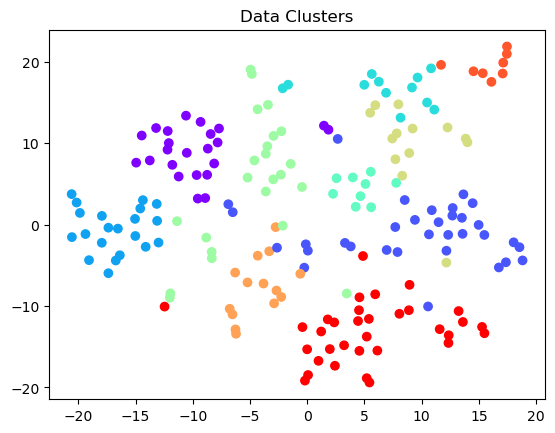

In [40]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(
    n_components=2, 
    perplexity=25, 
    early_exaggeration=2, 
    random_state=10
)

two_dim_data = tsne.fit_transform(vectors)

plt.scatter(
    x=two_dim_data[:, 0], 
    y=two_dim_data[:, 1], 
    c=kmeans.labels_, 
    cmap='rainbow'
)
plt.title('Data Clusters')
plt.show()

#### Get the closest embedding to each cluster centroid

In [41]:
closest_indices_list = []

for i in range(n_clusters):
    distances = np.linalg.norm(vectors - kmeans.cluster_centers_[i], axis=1)
    closest_index = np.argmin(distances)
    closest_indices_list.append(closest_index)

closest_indices_list.sort()

In [42]:
closest_indices_list

[1, 26, 67, 80, 88, 105, 110, 113, 134, 176]

#### Create prompt template that is to be applied for each cluster centroid

In [43]:
from langchain import PromptTemplate
map_prompt = """
Provide a short summary of the following in a single paragraph: 
{text}
"""
map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])

#### Map the prompt to all cluster centroid

In [44]:
map_chain = load_summarize_chain(
    llm=llm,
    chain_type="stuff",
    prompt=map_prompt_template
)

In [45]:
selected_docs = [docs[doc] for doc in closest_indices_list]

#### Summaries 

In [46]:
new_line = "\n"

summary_list = []
for i, doc in enumerate(selected_docs):
    chunk_summary = map_chain.run([doc])
    summary_list.append(chunk_summary)
    print(f"[{i+1}] Cluster Centroid Summary: {chunk_summary}")
    print()

[1] Cluster Centroid Summary: architectures. It focuses on key areas such as security, reliability, performance efficiency, cost optimization, and operational excellence. By using the framework, you can assess your architecture and identify areas where improvements can be made to ensure a well-architected system. AWS Solutions Architects, with their extensive experience, can provide guidance and assistance in designing and reviewing architectures to help businesses achieve success in the cloud.

[2] Cluster Centroid Summary: responsibility for its success. This requires effective communication, collaboration, and coordination among team members. Additionally, it is important to establish clear roles and responsibilities within the organization to ensure that everyone knows what is expected of them. Prepare
Before deploying your workload, it is important to thoroughly plan and prepare for its implementation. This includes identifying any potential risks or challenges that may arise and 

## Abstractive-Abstractive Summarization

This type of summarization applies an abstractive summarization technique to the data two or more times.

### Method 1: Rerank

The map re-rank documents chain first summarizes each document. It not only provides a response but it also gives a score for confidence. Finally, it picks the response with the highest confidence score.

In [47]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CohereRerank
from langchain.chains import RetrievalQA
from langchain.vectorstores import FAISS

#### Create vector store

In [48]:
embedder = OpenAIEmbeddings()
vector_store = FAISS.from_documents(docs, embedder)

retriever = vector_store.as_retriever()

#### Create compressor

In [49]:
compressor = CohereRerank(user_agent="summarization")

#### Create Retriever

In [50]:
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, 
    base_retriever=retriever
)

#### Create Chain

In [51]:
chain = RetrievalQA.from_chain_type(
    llm=llm, 
    retriever=compression_retriever
)

In [52]:
chain.run("Provide a consolidated summary of the AWS Well Architected Framework based on the documentation")

'The AWS Well-Architected Framework is a set of best practices that helps users understand the advantages and disadvantages of decisions made when building systems on AWS. It provides guidance on designing and operating reliable, secure, efficient, cost-effective, and sustainable systems in the cloud. The framework consists of six pillars: operational excellence, security, reliability, performance efficiency, cost optimization, and sustainability. These pillars define the qualities expected from modern cloud-based systems and provide a consistent approach to evaluating architectures against these qualities. The framework is intended for technology roles such as CTOs, architects, developers, and operations team members, and provides best practices, strategies, and implementation details for designing and operating cloud workloads. It also emphasizes the importance of trade-offs and continuous improvement.'

### Method 2: Map-Reduce

The map reduce method splits the data into chunks and performs summarization on each chunk. It then combines the summaries of each chunk into a single summary.

In [53]:
from langchain.chains import MapReduceDocumentsChain, ReduceDocumentsChain
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains.llm import LLMChain

#### Map prompt template

In [54]:
map_template = """
The following is a list of documents:
{docs}
From the list, extract the over arching themes in a detailed manner.
Helpful Answer:"""

#### Map chain

In [55]:
map_prompt = PromptTemplate.from_template(map_template)
map_chain = LLMChain(
    llm=llm, 
    prompt=map_prompt
)

#### Reduce prompt template

In [56]:
reduce_template = """
The following is list of summaries:
{doc_summaries}


Consolidate the list into a single summary of a couple of paragraphs that details all the important information.
Helpful Answer:"""
reduce_prompt = PromptTemplate.from_template(reduce_template)

#### Reduce chain

In [57]:
reduce_chain = LLMChain(llm=llm, prompt=reduce_prompt)

combine_documents_chain = StuffDocumentsChain(
    llm_chain=reduce_chain, 
    document_variable_name="doc_summaries"
)

In [58]:
reduce_documents_chain = ReduceDocumentsChain(
    combine_documents_chain=combine_documents_chain,
    collapse_documents_chain=combine_documents_chain,
    token_max=100_000,
)

#### Map-Reduce Chain

In [59]:
map_reduce_chain = MapReduceDocumentsChain(
    llm_chain=map_chain,
    reduce_documents_chain=reduce_documents_chain,
    document_variable_name="docs",
    return_intermediate_steps=False,
)

#### To reduce compute time we are applying the chain on the first 25 chunks

In [60]:
%%time
print(map_reduce_chain.run(docs[:25]))

The provided list of documents highlights several overarching themes related to the AWS Well-Architected Framework and best practices for designing and operating systems on AWS. The documents emphasize the importance of following architectural best practices, making informed decisions, prioritizing reliability and security, optimizing efficiency and cost-effectiveness, and continuously improving system designs.

The AWS Well-Architected Framework serves as a guide for architects, developers, and operations team members in designing and operating cloud workloads effectively. It focuses on six key pillars: operational excellence, security, reliability, performance efficiency, cost optimization, and sustainability. These pillars provide a foundation for evaluating architectures and ensuring they align with cloud best practices.

The documents emphasize the need to understand the consequences of decisions made during the system-building process and make informed choices to ensure the succe